In [1]:
import tensorflow as tf
import cv2 as cv
import tarfile
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
#Path to downloaded pre-trained model
tar_path = "./ssd_mobilenet_v2_fpnlite_640x640_1.tar.gz"
#Path to where the extracted model is
extract_path = "./models/"
#Extract the downloaded model
with tarfile.open(tar_path, "r:gz") as file:
    file.extractall(path=extract_path)

In [11]:
#Load the extracted model
mobile_net = tf.saved_model.load(extract_path)
mobile_net = mobile_net.signatures["serving_default"]

In [12]:
#Read the input image
img = cv.imread(cv.samples.findFile("./boule.jpg"))
#Convert image to Tensorflow standard
b,g,r = cv.split(img)
img = cv.merge((r,g,b))
#Reshapre image to the input requirements for extracted model
img = cv.resize(img, (640,640))

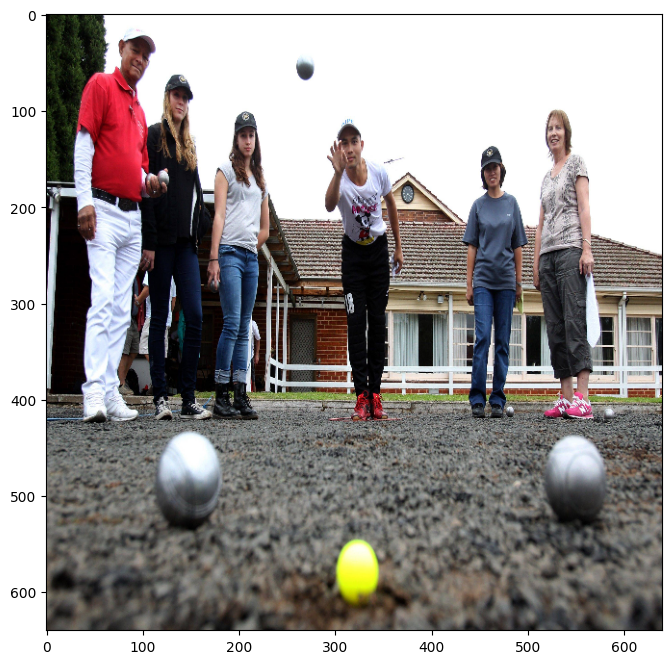

In [5]:
#Check to see so the resize hasn't distorted the image too much
plt.figure(figsize=(8,8))
plt.imshow(img)

In [6]:
#Convert to tensor so the extracted model can use it as input
img = tf.convert_to_tensor(img, dtype=tf.uint8)
#Add extra dimension for model requirements
img = tf.expand_dims(img, axis=0)

In [7]:
#Object detection predictions
output = mobile_net(img)

In [8]:
#Get boxes (Coordinates for boxes), scores (confidence score for prediction),
#and classes (What type of object has been found)
boxes = output["detection_boxes"].numpy()[0]
scores = output["detection_scores"].numpy()[0]
classes = output["detection_classes"].numpy()[0].astype(int)

Text(0.5, 1.0, 'ORIGINAL')

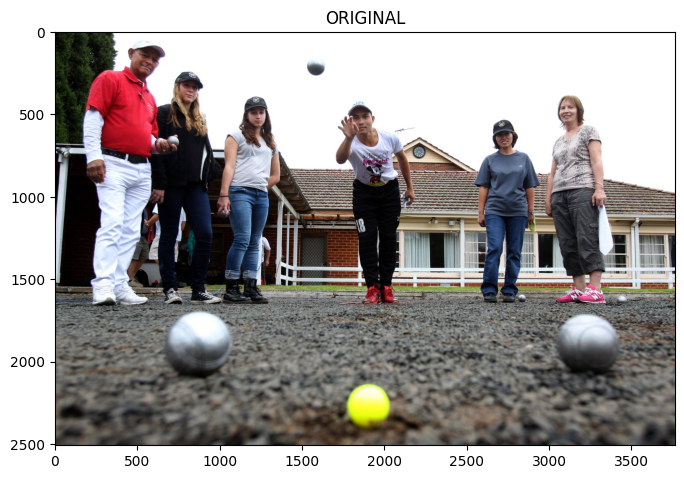

In [9]:
#Read original image to draw boundry boxes on
img_np = cv.imread(cv.samples.findFile("./boule.jpg"))

#Display image before drawing
plt.figure(figsize=(8,8))
plt.imshow(img_np[:,:,::-1])
plt.title("ORIGINAL")

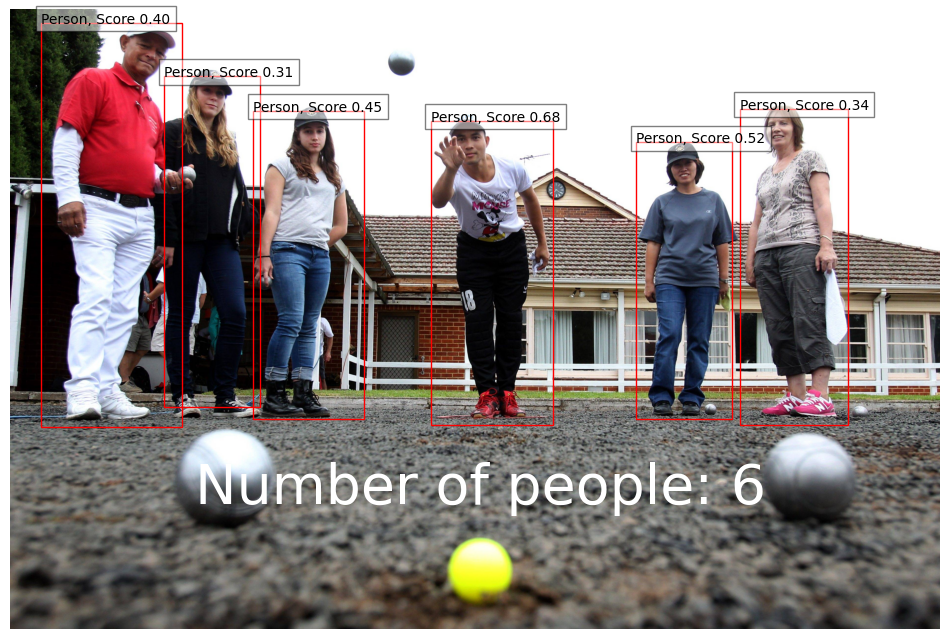

In [10]:
#Threshold value to only include the people we want
threshold = 0.3
#Counter for number of people
num_people = 0
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img_np[:,:,::-1])

for box, score, label in zip(boxes, scores, classes):
    #Only draw boundries on people (class = 1) and only include confidence levels
    #above threshold value
    if score > threshold and label == 1:
        num_people += 1
        #Find the coordinates of the detected objects (people), set the length and width with the min and max coordinates to draw a boundry box
        x, y = box[1] * img_np.shape[1], box[0] * img_np.shape[0]
        width = (box[3] - box[1]) * img_np.shape[1]
        height = (box[2] - box[0]) * img_np.shape[0]

        #Draw the boundry box
        ax.add_patch(patches.Rectangle((x, y), width, height, linewidth=1, edgecolor="r", facecolor="none"))
        #Add a label with the class name (1 == Person) and also add the confidence score of the detection being a person
        ax.text(x, y, f"Person, Score {score:.2f}", bbox=dict(facecolor="white", alpha=0.5))

text = f"Number of people: {num_people}"
ax.text(750,2000, text, color="white", fontsize=40)

plt.axis("off")
plt.show()